In [ ]:
! where pip
! pip install torchsummary
! pip install transformers
! pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu113

In [1]:
#import packages and check GPU availablity 
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms.autoaugment import TrivialAugmentWide
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import numpy as np
import os
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)
torch.__version__

cuda:0


'1.12.1'

# download dataset, 
# or you can download manually from https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset

In [ ]:
# install kaggle for downloading dataset
! pwd
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d vipoooool/new-plant-diseases-dataset

In [ ]:
! unzip new-plant-diseases-dataset.zip

In [ ]:
! mv "./New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)" "./dataset"

# define hyper parameters for training

In [2]:
#global variable and training param
if torch.cuda.is_available():
    torch.cuda.empty_cache()
epoch = 30
batch_size = 16
lr = 0.005
momentum = 0.9
gamma = 0.1
step_size = 4375

# loading images and labels from dataset
you may need to modify the path to your dataset

In [3]:
#load training and testing data
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#trainset = torchvision.datasets.ImageFolder('tomatoLeaf-3/train/images',transform = transform)
trainset = torchvision.datasets.ImageFolder('./New Plant Diseases Dataset(Augmented)/train',transform = transform)

print(len(trainset))




trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

#testset = torchvision.datasets.ImageFolder('tomatoLeaf-3/valid/images',transform = transform)
testset = torchvision.datasets.ImageFolder('./New Plant Diseases Dataset(Augmented)/valid',transform = transform)
print(len(testset))
#testset,validset = random_split(testset,[2585,2000])
testset,validset = random_split(testset,[10000,7572])

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

validloader = torch.utils.data.DataLoader(validset,batch_size = batch_size,
                                          shuffle = True, num_workers = 2)
classes = []
for name in os.listdir("./New Plant Diseases Dataset(Augmented)/train"):
#for name in os.listdir("./drive/MyDrive/Colab Notebooks/train/tomato"):
  classes.append(name)


70295
17572


In [4]:
len(classes)

38

# Show some example images

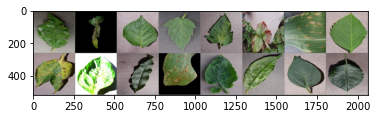

Cherry_(including_sour)___healthy Tomato___healthy Potato___Late_blight Tomato___Tomato_Yellow_Leaf_Curl_Virus Tomato___Septoria_leaf_spot Strawberry___healthy Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot Cherry_(including_sour)___Powdery_mildew Pepper,_bell___Bacterial_spot Pepper,_bell___healthy Peach___healthy Corn_(maize)___Common_rust_ Tomato___Target_Spot Cherry_(including_sour)___healthy Soybean___healthy Apple___healthy


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# load models [Vision transformer]
Just for testing performance of large models of ViT. Please do not use ViT for training because the model is too large.

In [ ]:
from transformers import ViTFeatureExtractor, ViTModel
from PIL import Image
import requests

url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
image = Image.open(requests.get(url, stream=True).raw)

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
inputs = feature_extractor(images=image, return_tensors="pt")

outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state


In [7]:
# some testing code, you can ignore it or run it if you like

inputs['pixel_values'].shape
type(outputs), model.config.hidden_size
test2=nn.Flatten()
test=nn.Linear(model.config.hidden_size, 20)
print(last_hidden_states[:,0,:].shape)
#flt = test2(last_hidden_states)
print(test(last_hidden_states[:,0,:]).shape)

torch.Size([1, 3, 224, 224])

# load tiny swin transformer for training and testing on our task

In [9]:
from transformers import AutoFeatureExtractor, SwinForImageClassification
from PIL import Image
import requests

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

#feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
model = SwinForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224")


D:\Anaconda3\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [10]:
class ViTForImageClassification2(nn.Module):

    def __init__(self, num_labels):

        super(ViTForImageClassification2, self).__init__()
        #self.vit = ViTModel.from_pretrained('google/vit-base-patch16-224-in21k')
        self.vit = SwinForImageClassification.from_pretrained("microsoft/swin-tiny-patch4-window7-224")
        #print(self.vit.config)
        self.classifier = nn.Linear(1000, num_labels)
        self.num_labels = num_labels

    def forward(self, pixel_values):

        outputs = self.vit(pixel_values=pixel_values)
        #print(outputs.logits.shape)
        logits = self.classifier(outputs.logits)
        #last_hidden_states=outputs.last_hidden_state
        #logits = self.classifier(last_hidden_states[:,0,:])
        return logits

model=ViTForImageClassification2(num_labels=len(classes))

# if you have any model already trained, you can use the following code to load it

In [10]:
model.load_state_dict(torch.load("./vit_leaf_classify.pth"))

<All keys matched successfully>

In [11]:
# just for testing
model(images).shape

torch.Size([16, 38])

# Define training optimizers and scheduler for updating learning rate

In [12]:
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
scheduler = optim.lr_scheduler.StepLR(optimizer, gamma = gamma,step_size=step_size, verbose = True)


Adjusting learning rate of group 0 to 5.0000e-03.


# train the model

In [ ]:
import gc
epoch = 4
for each in range(epoch):  # loop over the dataset multiple times
    print("epoch ", each)
    running_loss = 0.0
    model.train()
    for i, data in enumerate(trainloader, 0):
        gc.collect()
        torch.cuda.empty_cache()
        break
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device),data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        print(loss)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        print(running_loss)
        
        
    valid_loss = 0.0
    model.eval()
    for i, data in enumerate(validloader,0):
        gc.collect()
        torch.cuda.empty_cache()
        inputs, labels = data[0].to(device),data[1].to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        valid_loss += loss
        print(valid_loss)

    scheduler.step()
    print(f' train loss: {running_loss / len(trainloader)}, valid loss: {valid_loss / len(validloader)}')
    running_loss = 0.0       

print('Finished Training')
torch.save(model.state_dict(), '/vit_leaf_classify.pth')
print("Training saved")

In [13]:
torch.save(model.state_dict(), './vit_leaf_classify.pth')
print("Training saved")

Training saved
